# 1. Import Dependencies

In [2]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

# 2. Import df Amazon Sale Report

In [3]:
# Connection Parameter
host = 'localhost'
port = '5432'
database = 'airflow'
user = 'airflow'
password = 'airflow'

connection = psycopg2.connect(  
    host=host,
    port=port,
    database=database,
    user=user,
    password=password)
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

In [4]:
# Pull Amazon Sale Report df
result = engine.execute("SELECT * FROM amazon_sale_report")
rows = result.fetchall()
df = pd.DataFrame(rows, columns=result.keys())

# 3. df Preprocessing

In [5]:
# Columns name standardization
def column_standardization(df):
    columns_list = df.columns
    modified_columns_list = []
    for i in columns_list:
        modified_column = i.lower().replace(" ", "_").replace("-", "_").replace(":", "")
        modified_columns_list.append(modified_column)

    df.columns = modified_columns_list
    return df
df = column_standardization(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   order_id            128975 non-null  object 
 2   date                128975 non-null  object 
 3   status              128975 non-null  object 
 4   fulfilment          128975 non-null  object 
 5   sales_channel_      128975 non-null  object 
 6   ship_service_level  128975 non-null  object 
 7   style               128975 non-null  object 
 8   sku                 128975 non-null  object 
 9   category            128975 non-null  object 
 10  size                128975 non-null  object 
 11  asin                128975 non-null  object 
 12  courier_status      122103 non-null  object 
 13  qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  amount              121180 non-nul

In [7]:
df.set_index('index', inplace=True)

In [8]:
#Show Unique Values of dfset
print(df.nunique())

order_id              120378
date                      91
status                    13
fulfilment                 2
sales_channel_             2
ship_service_level         2
style                   1377
sku                     7195
category                   9
size                      11
asin                    7190
courier_status             3
qty                       10
currency                   1
amount                  1410
ship_city               8955
ship_state                69
ship_postal_code        9459
ship_country               1
promotion_ids           5787
b2b                        2
fulfilled_by               1
unnamed_22                 1
dtype: int64


order_id               0.000000
date                   0.000000
status                 0.000000
fulfilment             0.000000
sales_channel_         0.000000
ship_service_level     0.000000
style                  0.000000
sku                    0.000000
category               0.000000
size                   0.000000
asin                   0.000000
courier_status         5.328164
qty                    0.000000
currency               6.043807
amount                 6.043807
ship_city              0.025586
ship_state             0.025586
ship_postal_code       0.025586
ship_country           0.025586
promotion_ids         38.110487
b2b                    0.000000
fulfilled_by          69.546811
unnamed_22            38.030626
dtype: float64


<Axes: >

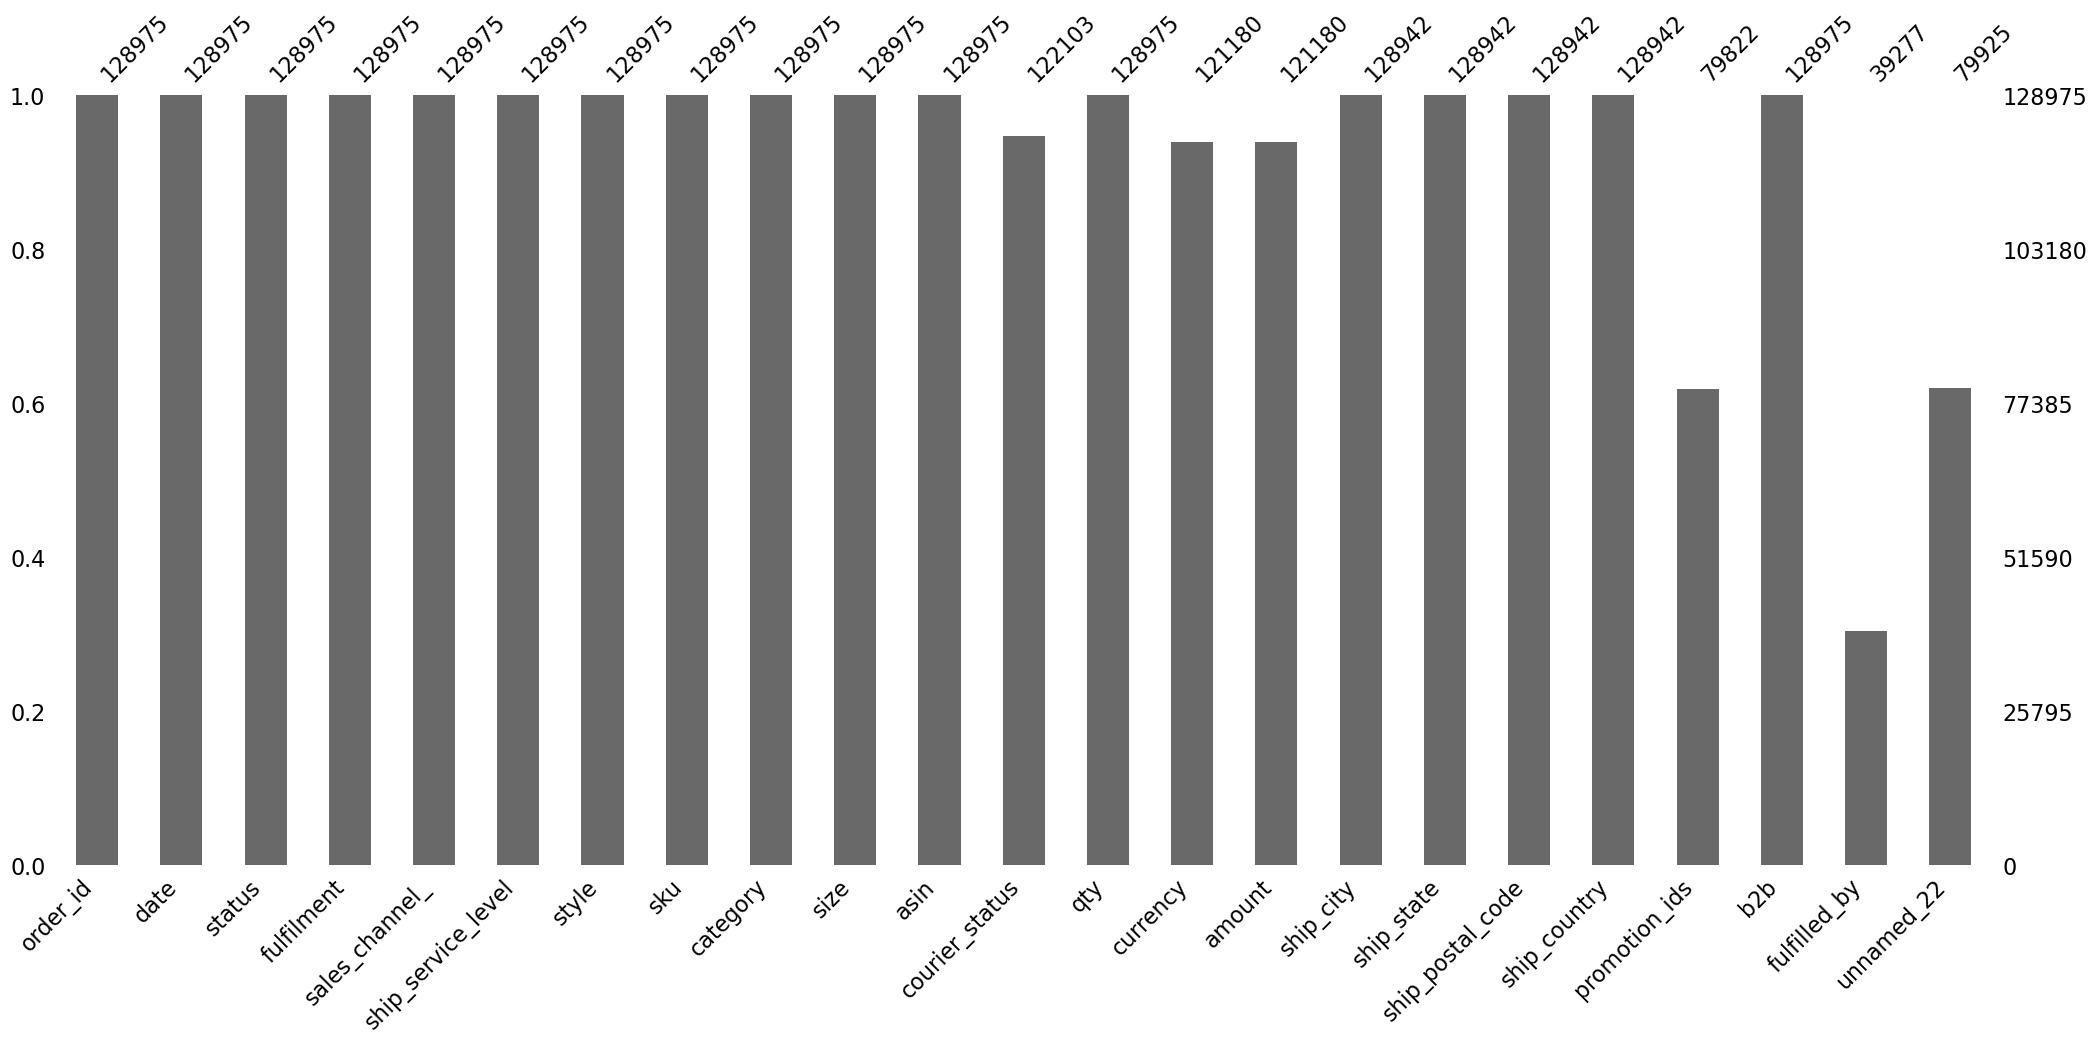

In [9]:
def nan_percentage(df):
    nan_percentage = (df.isna().sum()/len(df))*100
    return nan_percentage
print(nan_percentage(df))
msno.bar(df)

As you can see, column `promotion_ids`, `fulfilled_by`, and `unnamed_22` NaN df are quite high. `promotion_ids` NaN df about 38.1%, `fulfilled_by` about 69.5%, and `unnamed_22` about 38%. Suppose the maximum NaN value threshold for this project is:

* Above 30% null values: drop column
* Below 30% null values: drop rows or imputation

Not only that, column `currency`, `ship_country`, and `fulfilled_by` number of unique values are only 1. In conclusion, we have to drop these columns:
- `promotion_ids`
- `fulfilled_by`
- `Unnamed_22`
- `currency`
- `ship_country`

*Note: Assumed we don't use those columns in the future, so we could instantly ignore those columns.

In [10]:
df_unique = df.drop_duplicates()
duplicate_df = len(df) - len(df_unique)
print(f"Number of dropped duplicated df: {duplicate_df}")

drop_column_list = ['promotion_ids', 
                   'fulfilled_by', 
                   'unnamed_22', 
                   'currency', 
                   'ship_country']
df_drop = df_unique.drop(drop_column_list, axis=1)
df_drop_na = df_drop.dropna(subset=['courier_status', 
                                    'ship_city', 
                                    'ship_state', 
                                    'ship_postal_code'])

Number of dropped duplicated df: 6


In [23]:
def hist_boxplot(df, x, bins, title, x_label, y_label):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 0.5]}, sharex=True)
    sns.histplot(df[x], ax=ax[0], kde=True, kde_kws={'bw_adjust': 4}, bins=bins)
    ax[0].set_ylabel(y_label)
    sns.boxplot(x=df[x], ax=ax[1])
    
    mean = df[x].mean()
    median = df[x].median()
    mode = df[x].mode().values[0]
    q1 = df[x].quantile(0.25)
    q3 = df[x].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    if df['amount'].min(skipna=True) == 0:
        lower_limit = 0
    else:
        lower_limit = q1 - 1.5 * iqr

    stats_dict = {'mean': mean,
                  'median': median,
                  'mode': mode,
                  'q1': q1,
                  'q3': q3,
                  'upper limit': upper_limit,
                  'lower limit': lower_limit
                 }
    stats = pd.DataFrame(stats_dict, index=[0])

    for i in range(2):
        ax[i].axvline(mean, color='red', linestyle='--', label=f'Mean: {round(mean, 1)}', alpha=0.5)
        ax[i].axvline(median, color='green', linestyle='--', label=f'Median: {round(median, 1)}', alpha=0.5)
        ax[i].axvline(mode, color='blue', linestyle='--', label=f'Mode: {mode}', alpha=0.5)
        ax[i].axvline(upper_limit, color='orange', linestyle='--', label=f'Upper Limit: {round(upper_limit, 1)}', alpha=0.5)
        ax[i].axvline(lower_limit, color='purple', linestyle='--', label=f'Lower Limit: {round(lower_limit, 1)}', alpha=0.5)
    
    ax[0].legend()
    plt.suptitle(title)
    plt.xlabel(x_label)
    plt.tight_layout()
    plt.show()

    df_nan = df[df[x].isna()==True]
    df_no_outlier = df[(df[x]<=upper_limit)]
    df_no_outlier = pd.concat([df_nan, df_no_outlier], axis=0)
    
    df_outlier = df[df[x]>upper_limit]

    return df_no_outlier, df_outlier, stats

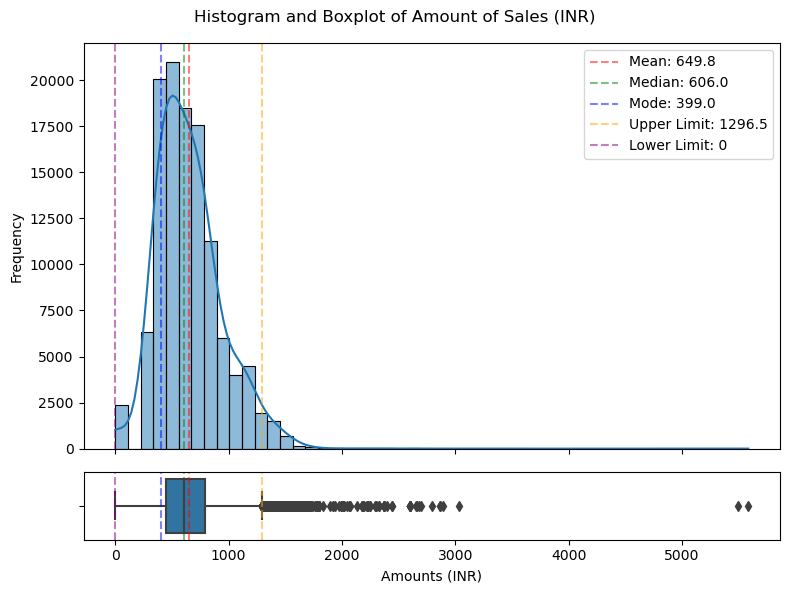

,mean,median,mode,q1,q3,upper limit,lower limit
0,649.774939,606.0,399.0,449.0,788.0,1296.5,0


In [12]:
df_no_outlier, df_outlier, stats = hist_boxplot(df_drop_na, 
                                         'amount', 
                                         50, 
                                         'Histogram and Boxplot of Amount of Sales (INR)', 
                                         'Amounts (INR)', 
                                         'Frequency')
display(stats)

From histogram pattern above we can conclude that the amounts of sales data is most likely following the normal distribution so we could impute the missing values with mean, median, or modus. But before doing all that, we need to handle the outlier first to avoid data bias (especially if we're using mean as imputation). 

Next step, we need to choose the best way to handle the outliers. 

In [13]:
outlier_percentage = (len(df_outlier)/len(df_drop_na))*100
print(f"The outlier proportion is {round(outlier_percentage, 2)}%")

The outlier proportion is 2.91%


The outlier proportion is fairly low, so we could neglect the outliers by using variable `df_no_outlier`. 

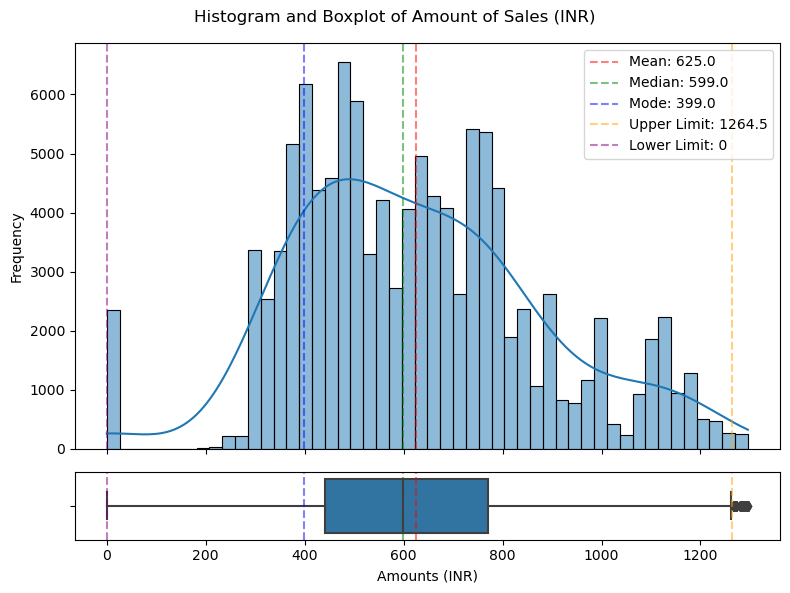

(                   order_id      date     status fulfilment sales_channel_  \
 index                                                                        
 8       407-5443024-5233168  04-30-22  Cancelled     Amazon      Amazon.in   
 65      171-4137548-0481151  04-30-22  Cancelled     Amazon      Amazon.in   
 84      403-9950518-0349133  04-30-22  Cancelled     Amazon      Amazon.in   
 95      405-9112089-3379536  04-30-22  Cancelled     Amazon      Amazon.in   
 101     402-7841951-1872363  04-30-22  Cancelled     Amazon      Amazon.in   
 ...                     ...       ...        ...        ...            ...   
 128970  406-6001380-7673107  05-31-22    Shipped     Amazon      Amazon.in   
 128971  402-9551604-7544318  05-31-22    Shipped     Amazon      Amazon.in   
 128972  407-9547469-3152358  05-31-22    Shipped     Amazon      Amazon.in   
 128973  402-6184140-0545956  05-31-22    Shipped     Amazon      Amazon.in   
 128974  408-7436540-8728312  05-31-22    Shipped   

In [24]:
hist_boxplot(df_no_outlier, 
            'amount', 
            50, 
            'Histogram and Boxplot of Amount of Sales (INR)', 
            'Amounts (INR)', 
            'Frequency')

In [15]:
df_no_outlier['datetime'] = pd.to_datetime(df_no_outlier.date)

<Axes: xlabel='datetime', ylabel='amount'>

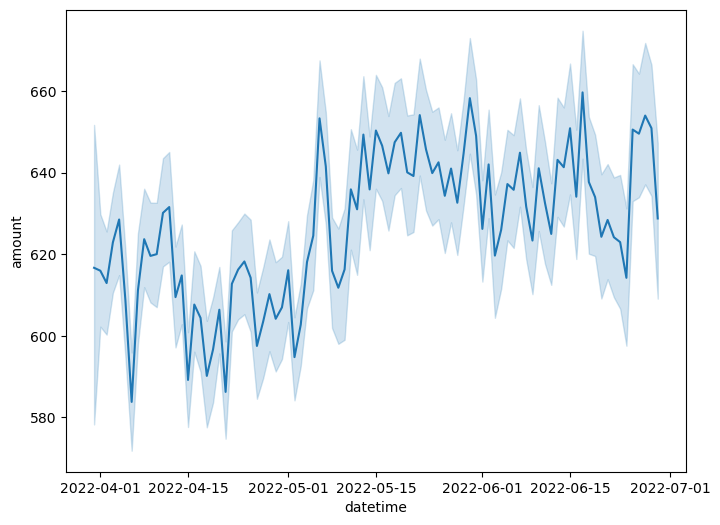

In [16]:
plt.figure(figsize=(8,6), dpi=100)
sns.lineplot(data=df_no_outlier, x='datetime', y='amount')

order_id              0.000000
date                  0.000000
status                0.000000
fulfilment            0.000000
sales_channel_        0.000000
ship_service_level    0.000000
style                 0.000000
sku                   0.000000
category              0.000000
size                  0.000000
asin                  0.000000
courier_status        0.000000
qty                   0.000000
amount                4.959571
ship_city             0.000000
ship_state            0.000000
ship_postal_code      0.000000
b2b                   0.000000
dtype: float64


<Axes: >

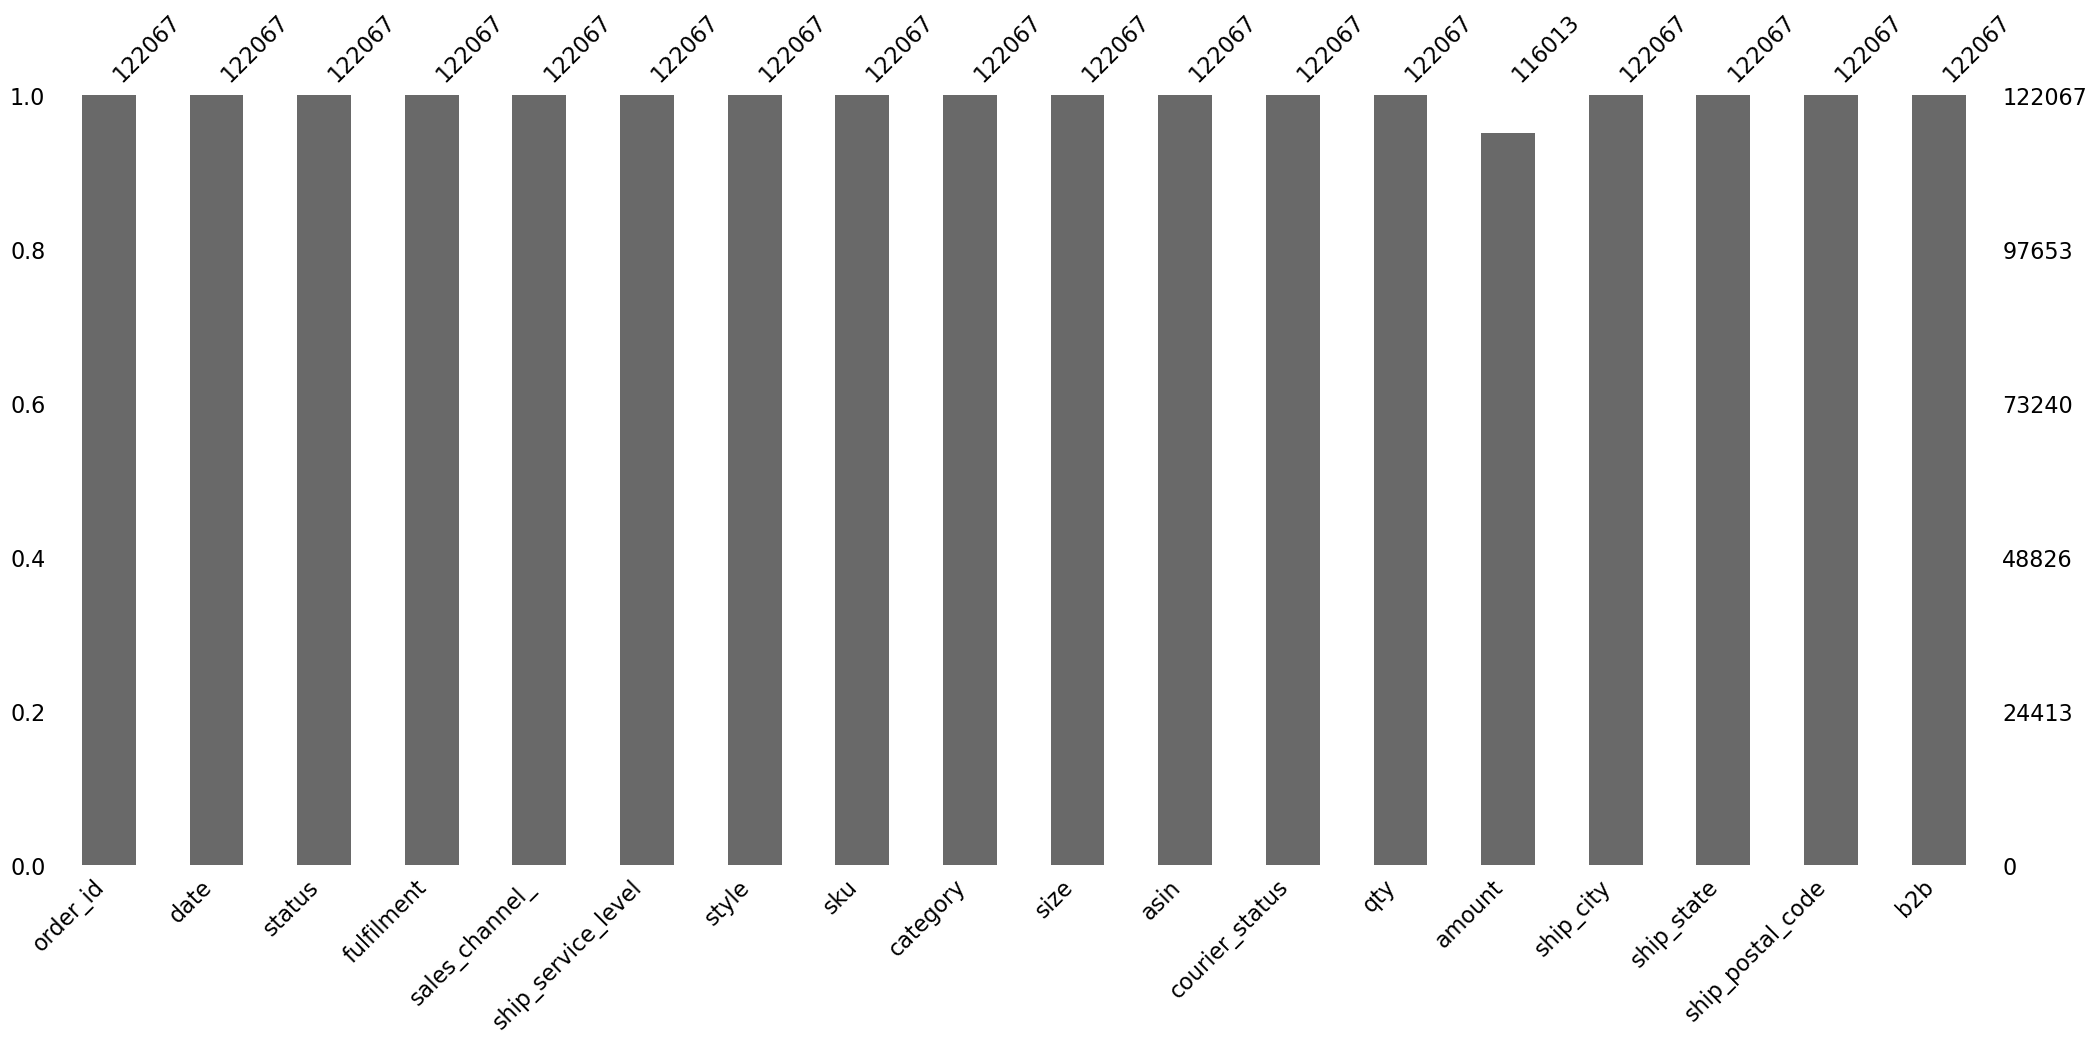

In [17]:
print(nan_percentage(df_drop_na))
msno.bar(df_drop_na)